In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 모든 경고 메시지 무시
warnings.filterwarnings("ignore")

In [44]:
ys_bert_rmr_basic = pd.read_csv("../data/processed/ys_bert_rmr_basic.csv", encoding="UTF-8")
ys_adverb_basic = pd.read_csv("../data/processed/ys_adverb_basic.csv", encoding="UTF-8")

In [45]:
def plot_label_count(df,df_name):
    grouped_data = df.groupby("label")["id"].count()
    grouped_data.plot(kind="bar", color="skyblue")
    plt.title(f"{df_name} label Count")
    plt.xlabel("label")
    plt.ylabel("Count")
    plt.show()

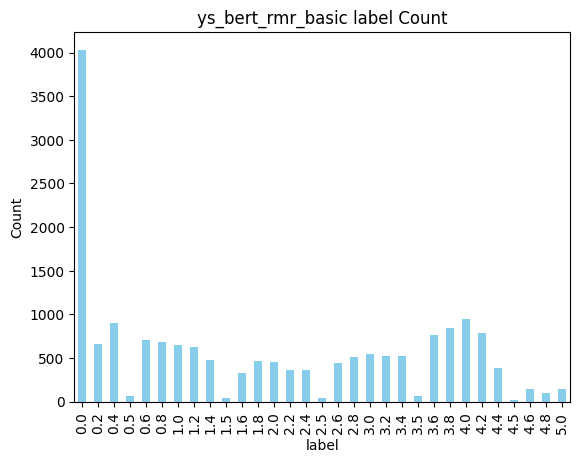

In [46]:
plot_label_count(ys_bert_rmr_basic, "ys_bert_rmr_basic")

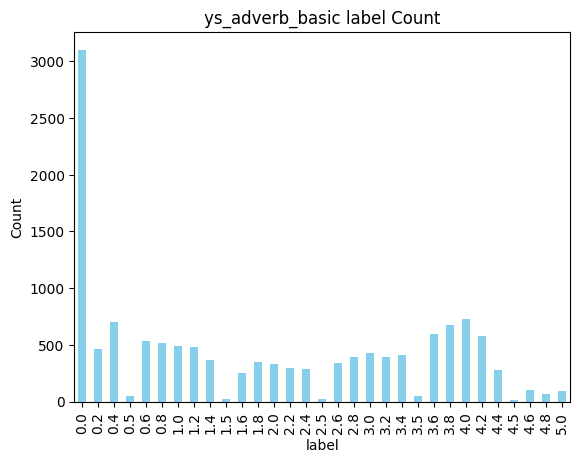

In [47]:
plot_label_count(ys_adverb_basic, "ys_adverb_basic")

In [48]:
def special_value_interpolation(df):
    # 0.5, 1.5, 2.5, 3.5, 4.5에 해당하는 값을 필터링
    target_values = [0.5, 1.5, 2.5, 3.5, 4.5]
    filtered_df = df[df["label"].isin(target_values)]


    # 각 값에 대해 절반은 +0.1, 절반은 -0.1
    def adjust_labels(group):
        n = len(group)
        # 절반으로 나눔
        half_n = n // 2
        # 첫 절반은 -0.1, 나머지는 +0.1
        group.iloc[:half_n] -= 0.1
        group.iloc[half_n:] += 0.1
        return group


    # 필터링된 값들에 대한 보정
    df.loc[df["label"].isin(target_values), "label"] = filtered_df.groupby("label")[
        "label"
    ].transform(adjust_labels)
    return df

In [49]:
def zero_five_balancing(df):
    # 0.0 분리
    zero_label_df = df[df["label"] == 0.0]
    non_zero_label_df = df[df["label"] != 0.0]
    sampled_zero_label_df = zero_label_df.sample(n=2000, random_state=42)

    # 5.0 증강 (500개의 첫 번째 데이터에 대해 변경)
    sampled_zero_label_df.iloc[:500, sampled_zero_label_df.columns.get_loc("label")] = (
        5.0
    )

    # 5.0 라벨인 데이터에 sentence_2에 sentence_1 복사
    sampled_zero_label_df.loc[sampled_zero_label_df["label"] == 5.0, "sentence_2"] = (
        sampled_zero_label_df["sentence_1"]
    )

    # 샘플링한 0.0/5.0 라벨 데이터와 나머지 데이터를 다시 합침
    reduced_df = pd.concat([sampled_zero_label_df, non_zero_label_df])
    return reduced_df.reset_index(drop=True)

In [50]:
from eda import eda


def swap_or_eda(df, alpha_sr=0.1, alpha_ri=0.1, alpha_rs=0.1, num_aug=1):
    """
    EDA 적용 함수 \n
    주의: 한글 제외한 나머지 문자 제거됨 \n
    alpha_sr: 특정 단어를 유의어로 교체할 확률 \n
    alpha_ri: 임의의 단어를 삽입할 확률 \n
    alpha_rs: 문장 내 임의의 두 단어의 위치를 바꿀 확률 \n
    num_aug: 데이터 증강하는 개수 \n
    """

    def _conditional_eda(row, column_name):
        if row["label"] in [4.6, 4.8]:
            return eda.EDA(row[column_name], alpha_sr, alpha_ri, alpha_rs, num_aug+1)
        if row["label"] in [1.6, 2.2, 2.4, 4.4]:
            return eda.EDA(row[column_name], alpha_sr, alpha_ri, alpha_rs, num_aug)
        else:
            return [row[column_name]]

    def swap_over_one_label(df):
        """sentence_1과 sentence_2를 교환한 데이터 추가"""
        df_swaped = df.rename(
            columns={"sentence_1": "sentence_2", "sentence_2": "sentence_1"}
        )
        df_filtered = df_swaped[
            ~df_swaped["label"].isin([0.0, 1.6, 2.2, 2.4, 4.4, 4.6, 4.8])
        ]

        return pd.concat([df, df_filtered])

    # sentence_1에 EDA 적용
    df["sentence_1"] = df.apply(lambda row: _conditional_eda(row, "sentence_1"), axis=1)
    df = df.explode("sentence_1").reset_index(drop=True)

    # sentence_2에 EDA 적용
    df["sentence_2"] = df.apply(lambda row: _conditional_eda(row, "sentence_2"), axis=1)
    df = df.explode("sentence_2").reset_index(drop=True)

    # sentence_1과 sentence_2를 교환
    df = swap_over_one_label(df)

    return df.reset_index(drop=True)

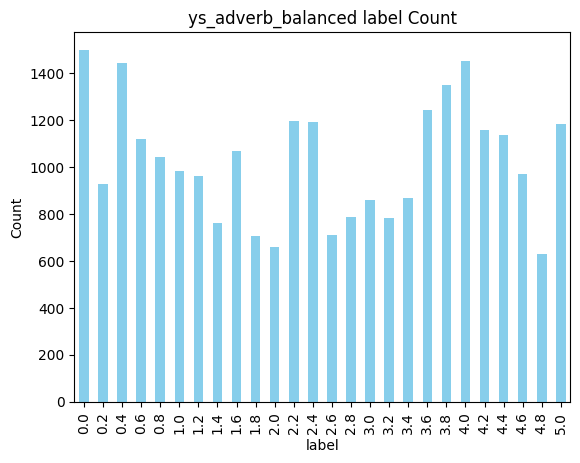

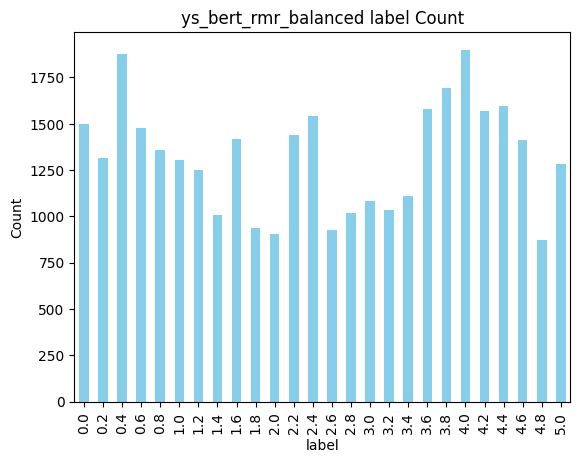

In [51]:
ys_adverb_balanced = special_value_interpolation(ys_adverb_basic)
ys_adverb_balanced = zero_five_balancing(ys_adverb_balanced)
ys_adverb_balanced = swap_or_eda(ys_adverb_balanced)
plot_label_count(ys_adverb_balanced, "ys_adverb_balanced")

ys_bert_rmr_balanced = special_value_interpolation(ys_bert_rmr_basic)
ys_bert_rmr_balanced = zero_five_balancing(ys_bert_rmr_balanced)
ys_bert_rmr_balanced = swap_or_eda(ys_bert_rmr_balanced)
plot_label_count(ys_bert_rmr_balanced, "ys_bert_rmr_balanced")

In [52]:
ys_adverb_balanced.to_csv("../data/ys_adverb_balanced.csv")
ys_bert_rmr_balanced.to_csv("../data/ys_bert_rmr_balanced.csv")